In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
#Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#Exploratory Climate Analysis

In [12]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [13]:
# Use the inspector to get the column names and data types within the 'measurement' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Use the inspector to get the column names and data types within the 'station' table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Last Date: ", last_date)

Last Date:  ('2017-08-23',)


In [60]:
# Calculate the date 1 year before the last data point (2017-08-23) using the datetime library
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [61]:
# Query all dates from 2016-08-23 until last data entry for prcp measurements
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

In [132]:
#save results as a Pandas DataFrame ordered by Dates as the index column
prcp_df = pd.DataFrame(prcp_data, columns = ['date', 'precipitation'])

prcp_df.set_index('date', inplace = True)

prcp_df = prcp_df.sort_index(ascending=True)

prcp_df.head(10)

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


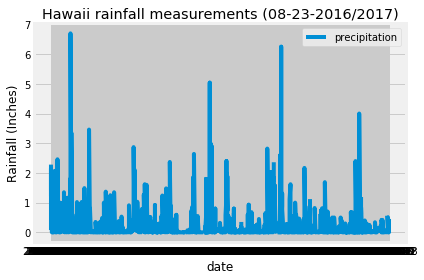

In [172]:
plt.plot(prcp_df['precipitation'])
plt.title("Hawaii rainfall measurements (08-23-2016/2017)")
plt.xlabel('date')
plt.ylabel('Rainfall (Inches)')
labels = ['precipitation']
plt.legend(labels)
plt.tight_layout()
plt.show()

In [64]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"There are {station_count} stations included in this dataset")

There are 9 stations included in this dataset


In [66]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Station.station, Station.name, func.count(Measurement.station)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

for result in station_activity:
    print(f"Station: {result[0]} ({result[1]}) Observation_Count: {result[2]}")

Station: USC00519281 (WAIHEE 837.5, HI US) Observation_Count: 2772
Station: USC00519397 (WAIKIKI 717.2, HI US) Observation_Count: 2724
Station: USC00513117 (KANEOHE 838.1, HI US) Observation_Count: 2709
Station: USC00519523 (WAIMANALO EXPERIMENTAL FARM, HI US) Observation_Count: 2669
Station: USC00516128 (MANOA LYON ARBO 785.2, HI US) Observation_Count: 2612
Station: USC00514830 (KUALOA RANCH HEADQUARTERS 886.9, HI US) Observation_Count: 2202
Station: USC00511918 (HONOLULU OBSERVATORY 702.2, HI US) Observation_Count: 1979
Station: USC00517948 (PEARL CITY, HI US) Observation_Count: 1372
Station: USC00518838 (UPPER WAHIAWA 874.3, HI US) Observation_Count: 511


In [67]:
most_active_station = session.query(Station.station, Station.name, func.count(Measurement.station)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).limit(1)

for result in most_active_station:
    print(f"Station #{result[0]} ({result[1]}) with an Observation Count of {result[2]} is the most active station")

Station #USC00519281 (WAIHEE 837.5, HI US) with an Observation Count of 2772 is the most active station


In [68]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = 'USC00519281'

temp_range = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature recorded at WAIHEE station: {temp_range[0][0]} Fahrenheit")
print(f"Highest Temperature recorded at WAIHEE station: {temp_range[0][1]} Fahrenheit")
print(f"Average Temperature recorded at WAIHEE station: {round(temp_range[0][2], 2)} Fahrenheit")

Lowest Temperature recorded at WAIHEE station: 54.0 Fahrenheit
Highest Temperature recorded at WAIHEE station: 85.0 Fahrenheit
Average Temperature recorded at WAIHEE station: 71.66 Fahrenheit


In [88]:
# Choose the station with the highest number of temperature observations, i.e. most_active_station).
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelve_month_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= query_date).all()

twelve_month_temps[:30]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0)]

In [89]:
#save results as a Pandas DataFrame ordered by Dates as the index column
twelve_month_temps_df = pd.DataFrame(twelve_month_temps, columns = ['date', 'temps'])

twelve_month_temps_df.set_index('date', inplace = True)

twelve_month_temps_df = twelve_month_temps_df.sort_index(ascending=True)

twelve_month_temps_df.head(10)

,temps
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


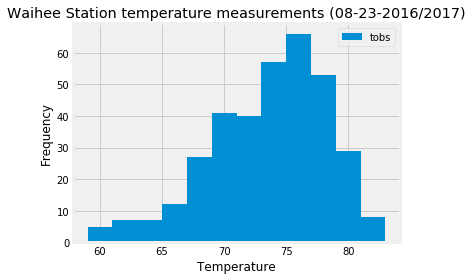

In [137]:
plt.hist(twelve_month_temps_df['temps'], bins=12)
plt.title("Waihee Station temperature measurements (08-23-2016/2017)")
plt.ylabel('Frequency')
plt.xlabel('Temperature')
labels = ['tobs']
plt.legend(labels)
plt.tight_layout()

In [ ]:
#Ran out of time to attempt Bonus section, hope to give it a go at a later date